# Olist Dataset

### Olist is a Brazilian e-commerce platform that enables small and medium-sized businesses to sell products across multiple online marketplaces. The Olist dataset contains transactional data, including order details, customer information, product attributes, payment methods, and reviews, providing insights into the platform's sales and customer behavior. It is commonly used for data analysis and machine learning projects aimed at understanding trends, predicting demand, and improving business strategies.

## Goal: Find how to increase customer satisfaction (so as to increase profit margin) while maintaining a healthy order volume?

### Meaning
### 1:Increase profit 
### 2:Keep operations balanced and scalable over time

### (I am going to solve the problem from sellers' perspective)

# Suggestion
## Olist should fire a small number of the worst underperforming sellers and shorten the average shipping time.

# Data exploration

## 1. Identify underperforming sellers
## 2. Calculate the impact of firing them
## 3. Set new policies for sellers

## １. Identify underperforming sellers
### Profit = Revenue(sales fee + subscription fee) - Cost(bad review cost + IT cost)
#### $(IT cost = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items})$

### I am going to identify sellers's performance based on the formula above

In [26]:
#Import libararies
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
from scipy import stats
from decimal import Decimal

In [2]:
#Import all tables(didn't use all)
from olist.data import Olist
df = Olist().get_data()
df.keys()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

In [3]:
#Caculate sales fee of each seller
sales = df["sellers"].merge(df["order_items"], on="seller_id", how="left")
sales = sales.groupby("seller_id")["price"].sum().reset_index()
sales["sales_fee"] = sales["price"]*0.1
sales

,seller_id,price,sales_fee
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,268.500
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03,2508.003
2,001e6ad469a905060d959994f1b41e4f,250.00,25.000
3,002100f778ceb8431b7a1020ff7ab48f,1234.50,123.450
4,003554e2dce176b5555353e4f3555ac8,120.00,12.000
...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,69.90,6.990
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,2101.20,210.120
3092,ffeee66ac5d5a62fe688b9d26f83f534,1839.86,183.986
3093,fffd5413c0700ac820c7069d66d98c89,9062.30,906.230


In [4]:
#Caculate subscription fee of each seller
from olist.seller import Seller
seller = Seller().get_training_data()
seller["subscription_fee"] = seller["months_on_olist"]*80
seller = seller[["seller_id", "subscription_fee"]]
seller

/Users/suzukikenta/code/KentaSuzukii/04-Decision-Science/01-Project-Setup/data-context-and-setup/olist/seller.py:100: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df = orders_sellers.groupby('seller_id').agg({
/Users/suzukikenta/code/KentaSuzukii/04-Decision-Science/01-Project-Setup/data-context-and-setup/olist/seller.py:100: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df = orders_sellers.groupby('seller_id').agg({


,seller_id,subscription_fee
0,3442f8959a84dea7ee197c632cb2df15,320.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,1120.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,0.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,0.0
4,51a04a8a6bdcb23deccc82b0b80742cf,0.0
...,...,...
2962,98dddbc4601dd4443ca174359b237166,0.0
2963,f8201cab383e484733266d1906e2fdfa,1120.0
2964,74871d19219c7d518d0090283e03c137,400.0
2965,e603cf3fec55f8697c9059638d6c8eb5,320.0


In [5]:
#Join the two tables
revenues = seller.merge(sales, on="seller_id", how="left")
revenues
revenues["total_revenue"] = revenues["sales_fee"] + revenues["subscription_fee"] 
revenues

,seller_id,subscription_fee,price,sales_fee,total_revenue
0,3442f8959a84dea7ee197c632cb2df15,320.0,218.70,21.870,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,1120.0,11703.07,1170.307,2290.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,0.0,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,0.0,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,0.0,167.99,16.799,16.799
...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,0.0,158.00,15.800,15.800
2963,f8201cab383e484733266d1906e2fdfa,1120.0,889.00,88.900,1208.900
2964,74871d19219c7d518d0090283e03c137,400.0,550.04,55.004,455.004
2965,e603cf3fec55f8697c9059638d6c8eb5,320.0,297.00,29.700,349.700


In [6]:
#Caculate bad review costs
cost_of_reviews = df["orders"].merge(df["order_reviews"], on="order_id", how="left")
cost_of_reviews = cost_of_reviews.merge(df["order_items"], on="order_id", how="left")
cost_of_reviews["three_star"] = cost_of_reviews["review_score"].apply(lambda x: 1 if x == 3 else 0)
cost_of_reviews["two_star"] = cost_of_reviews["review_score"].apply(lambda x: 1 if x == 2 else 0)
cost_of_reviews["one_star"] = cost_of_reviews["review_score"].apply(lambda x: 1 if x == 1 else 0)
cost_of_reviews = cost_of_reviews.groupby("seller_id")[["three_star", "two_star", "one_star"]].sum().reset_index()
cost_of_reviews["three_star"] = cost_of_reviews["three_star"]*40
cost_of_reviews["two_star"] = cost_of_reviews["two_star"] *50
cost_of_reviews["one_star"] = cost_of_reviews["one_star"] *100
cost_of_reviews["cost"] = cost_of_reviews["three_star"] + cost_of_reviews["two_star"] + cost_of_reviews["one_star"]
cost_of_reviews = cost_of_reviews.drop(columns=["three_star", "two_star", "one_star"])
cost_of_reviews

,seller_id,cost
0,0015a82c2db000af6aaaf3ae2ecb0532,100
1,001cca7ae9ae17fb1caed9dfb1094831,4750
2,001e6ad469a905060d959994f1b41e4f,100
3,002100f778ceb8431b7a1020ff7ab48f,1110
4,003554e2dce176b5555353e4f3555ac8,0
...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,100
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,240
3092,ffeee66ac5d5a62fe688b9d26f83f534,200
3093,fffd5413c0700ac820c7069d66d98c89,1360


In [7]:
#Caculate profit of each seller(excluding IT cost)
profits_1 = revenues.merge(cost_of_reviews, on="seller_id", how="left")
profits_1["profit"] = profits_1["total_revenue"] - profits_1["cost"]
profits_1 = profits_1[["seller_id", "profit"]]
profits_1

,seller_id,profit
0,3442f8959a84dea7ee197c632cb2df15,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,-83.201
...,...,...
2962,98dddbc4601dd4443ca174359b237166,15.800
2963,f8201cab383e484733266d1906e2fdfa,1068.900
2964,74871d19219c7d518d0090283e03c137,455.004
2965,e603cf3fec55f8697c9059638d6c8eb5,299.700


<Axes: >

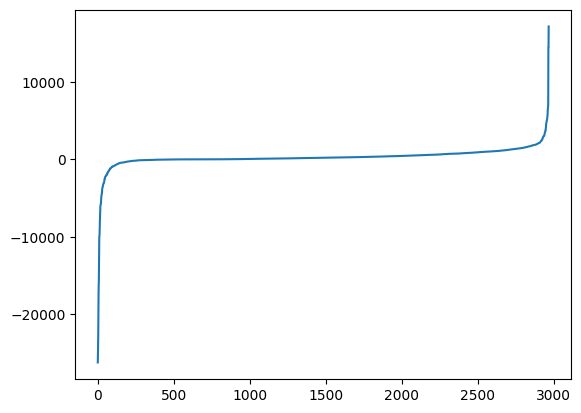

In [8]:
# Visualize profits of sellers
profits_1 = profits_1.sort_values(by='profit').reset_index()
profits_1.profit.plot()

## Most of them don't contribute much to the overall profit, and only a small percentage significantly impacts it, either positively or negatively.

In [9]:
#IT cost function
def IT_cost(number_of_sellers, number_of_items):
    return 3157.27 * np.sqrt(number_of_sellers) + 978.23 * np.sqrt(number_of_items)

In [16]:
#Number of products they sell
num_products = df["order_items"].merge(df["products"], on="product_id", how="left")
num_products = num_products.groupby("seller_id")["product_id"].nunique().reset_index()
num_products.rename(columns={'product_id': 'product_num'}, inplace=True)
num_products

,seller_id,product_num
0,0015a82c2db000af6aaaf3ae2ecb0532,1
1,001cca7ae9ae17fb1caed9dfb1094831,11
2,001e6ad469a905060d959994f1b41e4f,1
3,002100f778ceb8431b7a1020ff7ab48f,24
4,003554e2dce176b5555353e4f3555ac8,1
...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,1
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,12
3092,ffeee66ac5d5a62fe688b9d26f83f534,3
3093,fffd5413c0700ac820c7069d66d98c89,29


In [17]:
#Caculate profit of each seller(including IT cost)
profits = profits_1.sort_values("profit", ascending=False)
profits["cumulative_profit"] = profits["profit"].cumsum()
profits["unique_id"] = range(1, len(profits) + 1)
profits = profits.merge(num_products, on="seller_id", how="left")
profits.rename(columns={"product_id": "product_num"}, inplace=True)
profits["cumulative_product_num"] = profits["product_num"].cumsum()
profits["cumulative_IT_cost"] = profits.apply(lambda row: IT_cost(row["unique_id"], row["cumulative_product_num"]), axis=1)
profits["final_profit"] = profits["cumulative_profit"] - profits["cumulative_IT_cost"]
profits

,index,seller_id,profit,cumulative_profit,unique_id,product_num,cumulative_product_num,cumulative_IT_cost,final_profit
0,868,53243585a1d6dc2643021fd1853d8905,17197.605,17197.605,1,23,23,7848.696271,9348.908729
1,534,fa1c13f2614d7b5c4749cbc52fecda94,14494.203,31691.808,2,289,312,21744.040919,9947.767081
2,67,7e93a43ef30c4f03f38b393420bc753a,14483.187,46174.995,3,186,498,27298.648218,18876.346782
3,2151,edb1ef5e36e0c8cd84eb3c9b003e486d,7238.455,53413.450,4,55,553,29318.549757,24094.900243
4,9,ccc4bbb5f32a6ab2b7066a4130f114e3,6700.462,60113.912,5,12,565,30312.131999,29801.780001
...,...,...,...,...,...,...,...,...,...
2962,1357,cc419e0650a3c5ba77189a1882b7556a,-19121.158,929424.359,2963,37,33420,350692.659291,578731.699709
2963,2358,4a3ca9315b744ce9f8e9374361493884,-22972.708,906451.651,2964,399,33819,351786.022008,554665.628992
2964,1132,7c67e1448b00f6e969d365cea6b010ab,-23977.611,882474.040,2965,198,34017,352340.865428,530133.174572
2965,453,1f50f920176fa81dab994f9023523100,-25436.079,857037.961,2966,23,34040,352430.838609,504607.122391


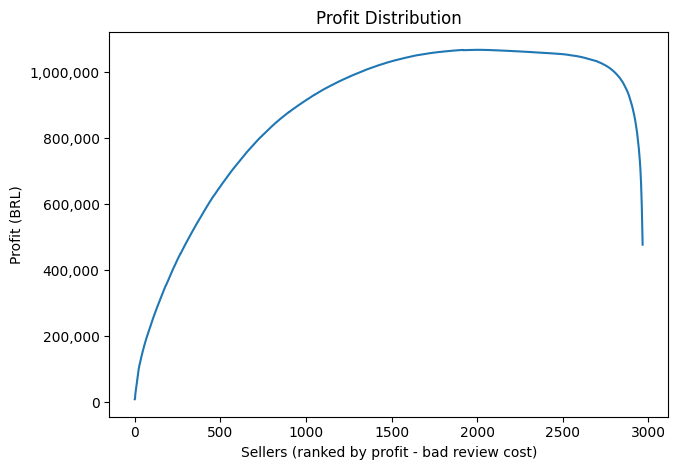

In [13]:
#Profit_transition
profits.final_profit.plot()
plt.title("Profit Distribution")
plt.xlabel("Sellers (ranked by profit - bad review cost)")
plt.ylabel("Profit (BRL)")
plt.tight_layout()
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

## 2.Caculate the impact of fireing them

### We have two options
### 1. Fire all sellers who are negatively contributing to the overall profit.
### 2. Fire only those sellers who are significantly negatively contributing to the overall profit.


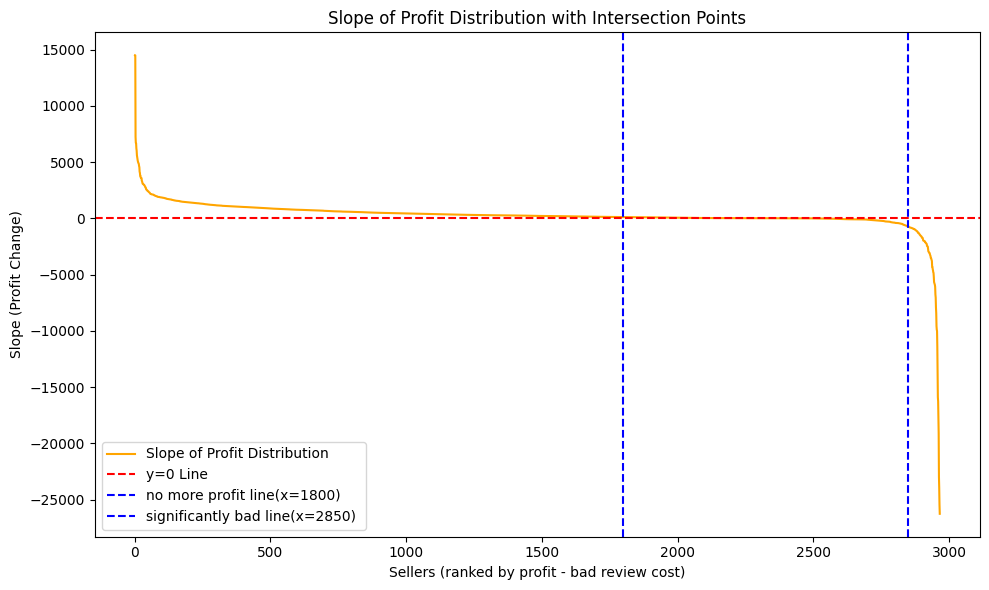

In [22]:
#Plot the slope of the previous graph to visualize how they contribute to the overall profit
plt.figure(figsize=(10, 6))
profits['slope'] = profits['cumulative_profit'].diff()
plt.plot(profits['slope'], label='Slope of Profit Distribution', color='orange')
plt.axhline(0, color='red', linestyle='--', label='y=0 Line')
plt.axvline(x=1800, color='blue', linestyle='--', label='no more profit line(x=1800)')
plt.axvline(x=2850, color='blue', linestyle='--', label='significantly bad line(x=2850) ')
plt.title("Slope of Profit Distribution with Intersection Points")
plt.xlabel("Sellers (ranked by profit - bad review cost)")
plt.ylabel("Slope (Profit Change)")
plt.tight_layout()
plt.legend()
plt.show()

## The slope remains zero from x = 1800 up to a certain point, indicating that these sellers do not contribute to profit at all. Beyond x = 2850, the slope starts to decrease sharply, meaning their contribution to profit becomes significantly negative.

In [23]:
#Caculate the impact of underperforming sellers
no_more_profits = profits[profits["unique_id"] >= 1800]
print("What if we excludes bad sellers")
print(f"Number of products you would lose: {no_more_profits['product_num'].sum()}")
print(f"Percentage of products you would lose is: {round(100*(no_more_profits["product_num"].sum()/profits["product_num"].sum()),1)}%")
very_bad_profits = profits[profits["unique_id"] >= 2850] 
print("What if we excludes very bad sellers")
print(f"Number of products you would lose: {very_bad_profits['product_num'].sum()}")
print(f"Percentage of products you would lose is: {round(100*(very_bad_profits["product_num"].sum()/profits["product_num"].sum()),1)}%")

What if we excludes bad sellers
Number of products you would lose: 14360
Percentage of products you would lose is: 41.9%
What if we excludes very bad sellers
Number of products you would lose: 8287
Percentage of products you would lose is: 24.2%


## if we exclude bad sellers....
### Number of products you would lose: 14360
### Percentage of products you would lose is: 41.9%
## if we exclude very bad sellers....
### Number of products you would lose: 8287
### Percentage of products you would lose is: 24.2%

## Maybe we could lose just 10% of all products...

In [18]:
from olist.seller import Seller
sell = Seller().get_training_data()
sell

/Users/suzukikenta/code/KentaSuzukii/04-Decision-Science/01-Project-Setup/data-context-and-setup/olist/seller.py:100: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df = orders_sellers.groupby('seller_id').agg({
/Users/suzukikenta/code/KentaSuzukii/04-Decision-Science/01-Project-Setup/data-context-and-setup/olist/seller.py:100: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df = orders_sellers.groupby('seller_id').agg({


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000000,218.70,0.333333,0.333333,3.000000
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025000,11703.07,0.731707,0.048780,4.560976
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000000,158.00,1.000000,0.000000,5.000000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000000,79.99,1.000000,0.000000,5.000000
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000000,167.99,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,2,2,1.000000,158.00,1.000000,0.000000,5.000000
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,10,10,1.000000,889.00,0.500000,0.100000,4.100000
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,6,7,1.166667,550.04,1.000000,0.000000,5.000000
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,8,11,1.375000,297.00,0.636364,0.000000,4.454545


In [24]:
#Decide how many people we should fire under the condition that we cannot lose more than 10% of production capability
product_num_value = no_more_profits.loc[no_more_profits['unique_id'] == 2967, 'cumulative_product_num'].values[0]
print(f"Total products:{product_num_value}")
print(f"10% of totla products:{product_num_value/10}")
lower_bound = product_num_value - (product_num_value / 10)
result = no_more_profits[no_more_profits['cumulative_product_num'].between(lower_bound, product_num_value)]
result['unique_id']
print(f"How many sellers you should fire: {len(result[['unique_id', 'cumulative_product_num']])}")                                                                 

Total products:34296
10% of totla products:3429.6
How many sellers you should fire: 26


### Total products:34296
### 10% of totla products:3429.6
### How many sellers you should fire: 26

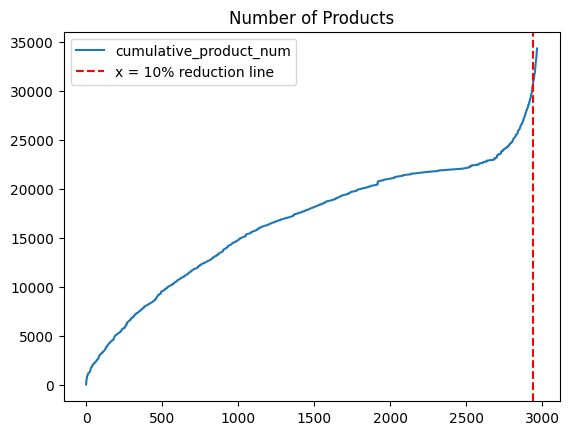

In [25]:
#Visualize cumulative number of products 
profits.cumulative_product_num.plot()
plt.axvline(x=2942, color='red', linestyle='--', label='x = 10% reduction line')
plt.legend()
plt.title("Number of Products")
plt.show()

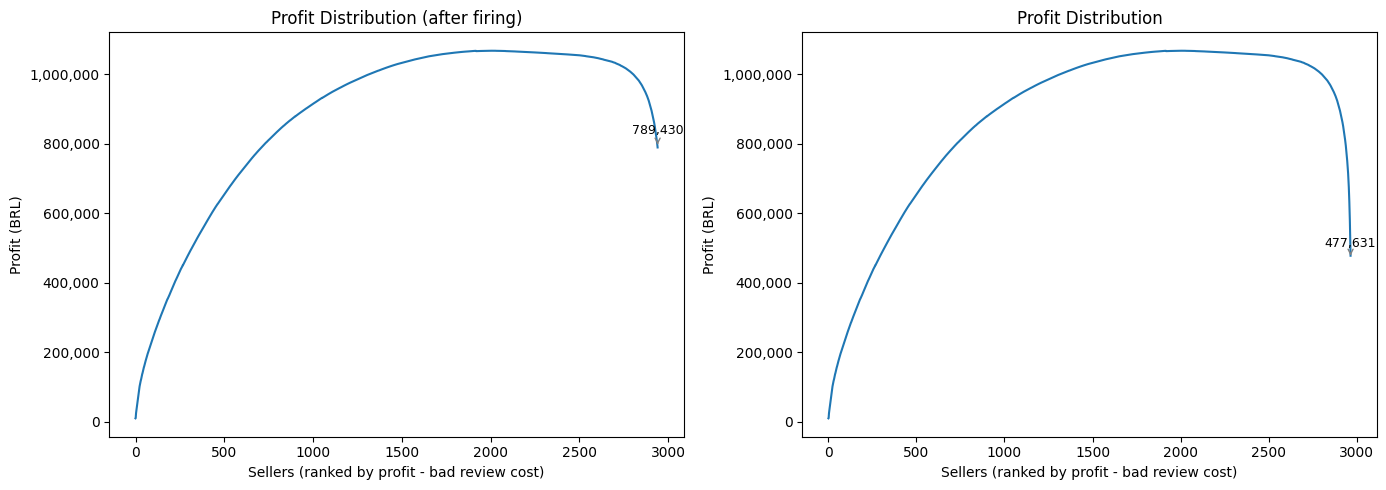

In [21]:
#Visualize the final profit if they had not exisited 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
profits_after_fire = profits[profits["unique_id"]<2942]
profits_after_fire.final_profit.plot(ax=axes[0])
axes[0].set_title("Profit Distribution (after firing)")
axes[0].set_xlabel("Sellers (ranked by profit - bad review cost)")
axes[0].set_ylabel("Profit (BRL)")
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
x0 = profits_after_fire.index[-1]
y0 = profits_after_fire.final_profit.iloc[-1]
axes[0].annotate(f'{y0:,.0f}', 
                 xy=(x0, y0), 
                 xytext=(x0, y0 + 0.05 * y0),
                 ha='center', fontsize=9,
                 arrowprops=dict(arrowstyle='->', color='gray'))
profits.final_profit.plot(ax=axes[1])
axes[1].set_title("Profit Distribution")
axes[1].set_xlabel("Sellers (ranked by profit - bad review cost)")
axes[1].set_ylabel("Profit (BRL)")
axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
x1 = profits.index[-1]
y1 = profits.final_profit.iloc[-1]
axes[1].annotate(f'{y1:,.0f}', 
                 xy=(x1, y1), 
                 xytext=(x1, y1 + 0.05 * y1),
                 ha='center', fontsize=9,
                 arrowprops=dict(arrowstyle='->', color='gray'))
plt.tight_layout()
plt.show()

### I recommend you to fire the 26 worst sellers which were responsible for 300,000 BRL loss(750万円).

# 3.Set new policies for sellers

## What separates "good sellers" from "bad sellers"?

## Diffences of shipping time

In [27]:
#Caculate average delivery time(in days)
df["orders"]['order_approved_at'] = pd.to_datetime(df["orders"]['order_approved_at'])
df["orders"]['order_delivered_carrier_date'] = pd.to_datetime(df["orders"]['order_delivered_carrier_date'])
df_shipping = df["orders"].merge(df["order_items"], on='order_id', how='left')
df_shipping['delivery_time_days'] = (df_shipping['order_delivered_carrier_date'] - df_shipping['order_approved_at']).dt.days
df_shipping = df_shipping.groupby('seller_id')['delivery_time_days'].mean().reset_index()
df_shipping

,seller_id,delivery_time_days
0,0015a82c2db000af6aaaf3ae2ecb0532,2.333333
1,001cca7ae9ae17fb1caed9dfb1094831,1.677824
2,001e6ad469a905060d959994f1b41e4f,NaN
3,002100f778ceb8431b7a1020ff7ab48f,3.018182
4,003554e2dce176b5555353e4f3555ac8,0.000000
...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,NaN
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,3.500000
3092,ffeee66ac5d5a62fe688b9d26f83f534,5.642857
3093,fffd5413c0700ac820c7069d66d98c89,1.459016


In [28]:
# Those who don't make profits
no_more_profits
no_more_profits = no_more_profits.merge(df_shipping,on='seller_id', how='left')
no_more_profits = no_more_profits.merge(df["sellers"],on='seller_id', how='left')
no_more_profits = no_more_profits[["seller_id","delivery_time_days"]]
no_more_profits 

,seller_id,delivery_time_days
0,1352e06ae67b410cdae0b2a22361167b,17.000000
1,adbe70ab2c97442046d393988c8d1d27,1.000000
2,74c7dec0a384d8a05950e629bd23bde9,4.000000
3,9da1ca0bef29ee170e541927a5aeabdc,1.333333
4,8ff38bc3969e67c36c48343a07090f66,7.000000
...,...,...
1163,cc419e0650a3c5ba77189a1882b7556a,1.886364
1164,4a3ca9315b744ce9f8e9374361493884,1.848943
1165,7c67e1448b00f6e969d365cea6b010ab,11.078561
1166,1f50f920176fa81dab994f9023523100,2.885552


In [29]:
#Only those who make profits
create_profits = profits[profits["unique_id"] < 1800]
create_profits = create_profits.merge(df_shipping,on='seller_id', how='left')
create_profits = create_profits.merge(df["sellers"],on='seller_id', how='left')
create_profits = create_profits[["seller_id","delivery_time_days"]]
create_profits

,seller_id,delivery_time_days
0,53243585a1d6dc2643021fd1853d8905,2.678218
1,fa1c13f2614d7b5c4749cbc52fecda94,1.837050
2,7e93a43ef30c4f03f38b393420bc753a,1.908257
3,edb1ef5e36e0c8cd84eb3c9b003e486d,0.874286
4,ccc4bbb5f32a6ab2b7066a4130f114e3,2.296875
...,...,...
1794,b33aaadd1a8891d2dfef0c4c3bdf0371,0.823529
1795,714b9a1332840f257b49f476bea4e341,1.333333
1796,28fb0829fd777877cdc350d25cb5bd5b,0.500000
1797,0ec28cec4046a4a199b6de9b4c891d97,2.250000


In [25]:
#waiting time
print(f"Shipping time of bad sellers:{no_more_profits["delivery_time_days"].mean()}")
print(f"Shipping time of good sellers:{create_profits["delivery_time_days"].mean()}")

Shipping time of bad sellers:3.0820830435877786
Shipping time of good sellers:2.436006433751582


In [30]:
# Assuming `no_more_profits` and `create_profits` are your DataFrames
# Extract the shipping times for bad and good sellers
bad_sellers_times = no_more_profits['delivery_time_days']
good_sellers_times = create_profits['delivery_time_days']

# Perform an independent t-test
t_statistic, p_value = stats.ttest_ind(bad_sellers_times, good_sellers_times, equal_var=False)

# Function to display the first non-zero digit after decimal
def format_significant(value):
    # Using Decimal to strip trailing zeros and keep the significant digits
    return str(Decimal(value).normalize())

# Print the results with the first significant digit after decimal
print(f"Shipping time of bad sellers: {format_significant(bad_sellers_times.mean())}")
print(f"Shipping time of good sellers: {format_significant(good_sellers_times.mean())}")
print(f"T-statistic: {format_significant(t_statistic)}")
print(f"P-value: {format_significant(p_value)}")

# Conclusion based on p-value
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in shipping times between bad and good sellers.")
else:
    print("Fail to reject the null hypothesis: There ibs no significant difference in shipping times between bad and good sellers.")


Shipping time of bad sellers: 3.08208304358777862574925166
Shipping time of good sellers: 2.436006433751582100910582085
T-statistic: 4.079013964282761861568360473
P-value: 0.0000472345243198047588556627574
Reject the null hypothesis: There is a significant difference in shipping times between bad and good sellers.


### Average shipping time of bad sellers: 3.0 days
### Average shipping time of good sellers: 2.4 days

## Do the two shipping times happen to be differnt? Let's test
### P-value: 0.00004
### Reject the null hypothesis: There is a significant difference in shipping times between bad and good sellers.

## Suggestion
### We could reward sellers with short shipping time

## Regional Differnces

In [27]:
# Normalize the value counts for no_more_profits
no_more_profits_state = no_more_profits["seller_state"].value_counts(normalize=True)

# Normalize the value counts for create_profits
create_profits_state = create_profits["seller_state"].value_counts(normalize=True)

# Merge the two normalized counts into one DataFrame
comparison = pd.DataFrame({
    'no_more_profits': no_more_profits_state,
    'create_profits': create_profits_state
}).fillna(0)  # Fill NaN values with 0 if a state is missing in one of the datasetss

# Display the comparison
print(comparison)


              no_more_profits  create_profits
seller_state                                 
AM                   0.000856        0.000000
BA                   0.004281        0.007226
CE                   0.004281        0.003891
DF                   0.006849        0.012229
ES                   0.008562        0.006670
GO                   0.015411        0.011673
MA                   0.000856        0.000000
MG                   0.076199        0.081712
MS                   0.000856        0.002223
MT                   0.000000        0.002223
PA                   0.000000        0.000556
PB                   0.002568        0.001668
PE                   0.001712        0.003891
PI                   0.000000        0.000556
PR                   0.101884        0.118955
RJ                   0.053938        0.055586
RN                   0.001712        0.001668
RO                   0.000000        0.001112
RS                   0.041096        0.042802
SC                   0.059932     

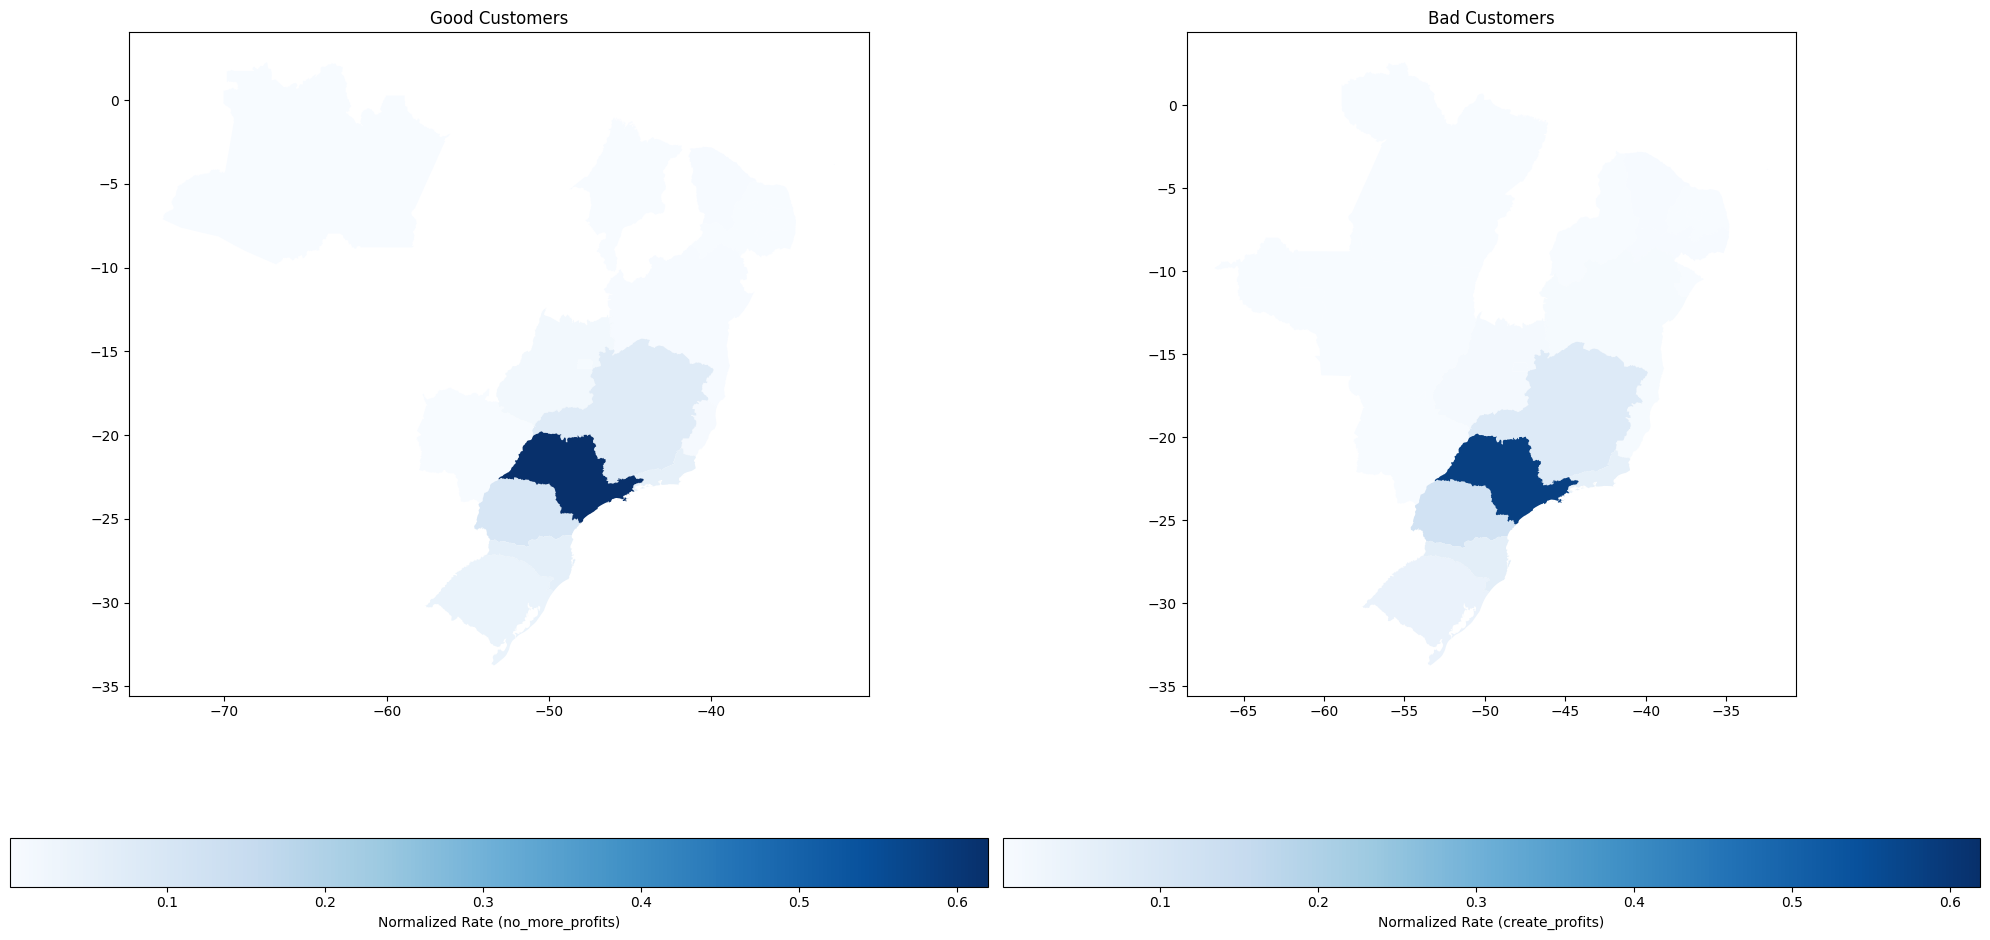

In [28]:
# Load the map of Brazil's states
brazil_states_map = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')

# Normalize the value counts for no_more_profits
no_more_profits_state = no_more_profits["seller_state"].value_counts(normalize=True)

# Normalize the value counts for create_profits
create_profits_state = create_profits["seller_state"].value_counts(normalize=True)

# Merge the normalized value counts with the map of Brazil
brazil_states_map = brazil_states_map.set_index('sigla')

# Join the comparison data with the map of Brazil
brazil_states_map['no_more_profits'] = brazil_states_map.index.map(no_more_profits_state)
brazil_states_map['create_profits'] = brazil_states_map.index.map(create_profits_state)

# Set the same color scale for both maps
vmin = min(brazil_states_map['no_more_profits'].min(), brazil_states_map['create_profits'].min())
vmax = max(brazil_states_map['no_more_profits'].max(), brazil_states_map['create_profits'].max())

# Plot the first map for no_more_profits
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot no_more_profits map (color each state based on 'no_more_profits' rate)
brazil_states_map.plot(ax=ax[0], column='no_more_profits', cmap='Blues', legend=True, 
                       legend_kwds={'label': "Normalized Rate (no_more_profits)", 'orientation': "horizontal"},
                       vmin=vmin, vmax=vmax)
ax[0].set_title("Good Customers")

# Plot create_profits map (color each state based on 'create_profits' rate)
brazil_states_map.plot(ax=ax[1], column='create_profits', cmap='Blues', legend=True, 
                       legend_kwds={'label': "Normalized Rate (create_profits)", 'orientation': "horizontal"},
                       vmin=vmin, vmax=vmax)
ax[1].set_title("Bad Customers")

# Show the plots
plt.tight_layout()
plt.show()



## There is no obvious regional differnce